# Segmentation to coordinates

This notebook explains how we can go from image segmentation to object coordinates. 


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import os
import pickle

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

Get project and datasets to get some predictions from the model.

In [2]:
project = TrackingProject(name="mouseTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/mouseTrack
Loading /home/kevin/Documents/trackingProjects/mouseTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'mouseTrack', 'normalization_values': {'means': [0.3958178758621216, 0.39585205912590027, 0.39564093947410583], 'stds': [0.11448581516742706, 0.11446335166692734, 0.11462123692035675]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['snout', 'earL', 'earR', 'tail'], 'target_radius': 5}


In [3]:
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 

In [4]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /home/kevin/Documents/trackingProjects/mouseTrack/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.3958178758621216, 0.39585205912590027, 0.39564093947410583], std=[0.11448581516742706, 0.11446335166692734, 0.11462123692035675], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [5]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

In [6]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [7]:
imageIndex=3
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

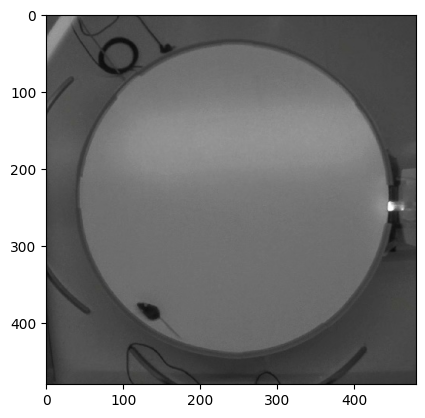

In [8]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [9]:
img = image.permute(1,2,0).numpy() #
msk = mask.numpy() 

### Image and masks for an item of the validation set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


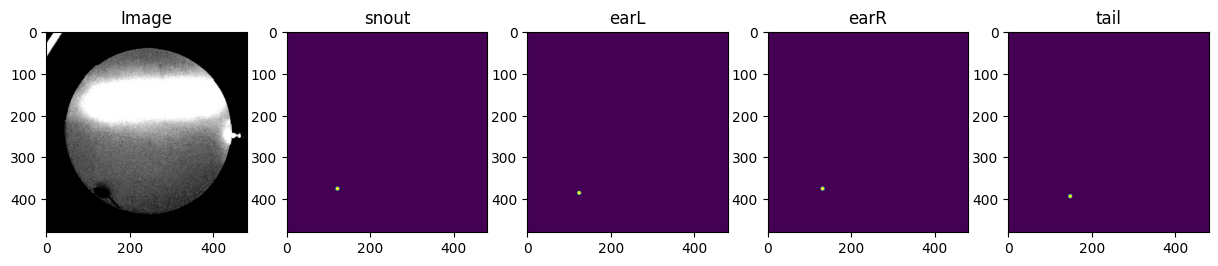

In [10]:
fig, ax = plt.subplots(1,msk.shape[0]+1,figsize=((msk.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(msk.shape[0]):
    ax[i+1].imshow(msk[i])
    ax[i+1].set_title(project.object_list[i])

### Image and mask predictions of an item of the validation set
Let's get the model output for this image. 

If you use [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), you should apply a sigmoid function to the output as it is usually applied when calculating the loss. 

The sigmoid function limits the range from 0 to 1. 

In [11]:
%%time

image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

CPU times: user 563 ms, sys: 216 ms, total: 779 ms
Wall time: 768 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


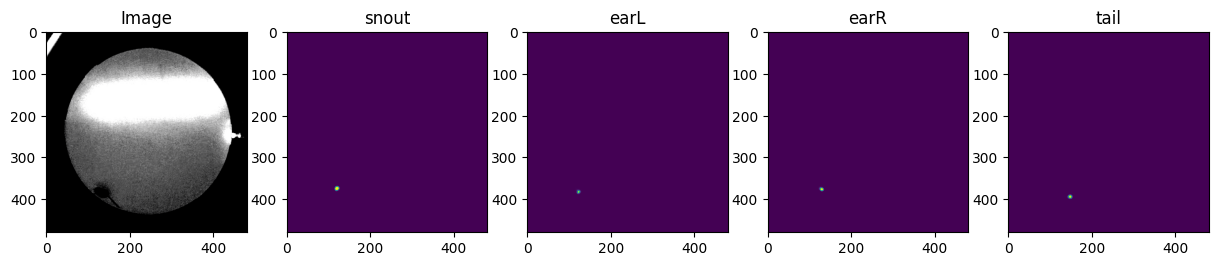

In [12]:
fig, ax = plt.subplots(1,output.shape[1]+1,figsize=((output.shape[1]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(output.shape[1]):
    ax[i+1].imshow(output[0,i])
    ax[i+1].set_title(project.object_list[i])

## Extracting coordinate out of the mask

A detected object appears as a bright blob in a dark background. 

We can use the cv2.SimpleBlobDetector to detect the objects.

In [13]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 30 # 100 # between 400 and 500 is the decision point
detector = cv2.SimpleBlobDetector_create(params)

In [14]:
blobs = imageOri.astype(np.uint8)
nObjects = output.shape[1]
pred = np.empty((output.shape[0],nObjects,3)) # x, y, probability
pred[:,:,:] = np.nan
pred[:,:,2] = output.reshape(nObjects,-1).max(axis=1) # maximal value in each object mask

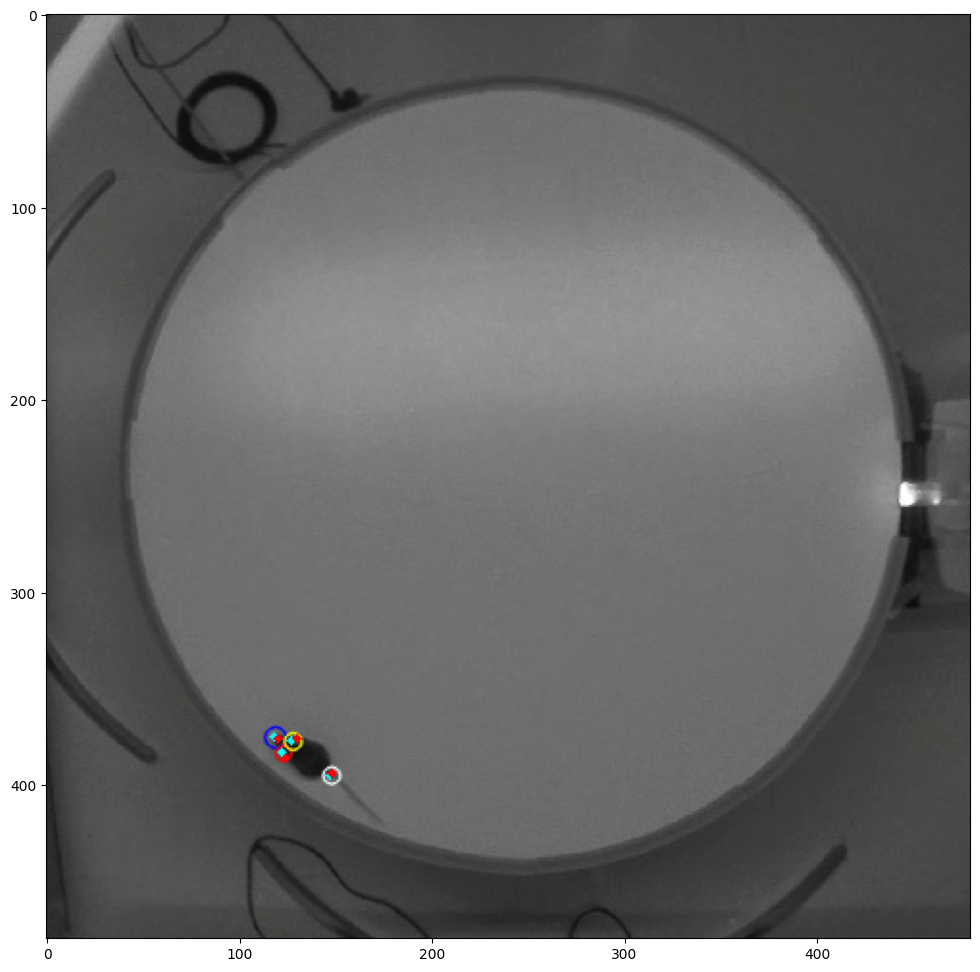

[[[118.82643127 375.41693115   0.99844676]
  [122.85823059 383.61868286   0.66364616]
  [127.88187408 377.46713257   0.97251159]
  [147.96641541 395.13092041   0.95597738]]]
[[120. 376.]
 [124. 386.]
 [130. 376.]
 [148. 394.]]


array([1.31043231, 2.64089165, 2.57661316, 1.13141898])

In [15]:
for item in range(1):
    for objectIndex in range(len(project.object_list)):

        out = output[item]
        outputT = np.expand_dims((out[objectIndex]*255).astype(np.uint8),2) # get output in unsigned int 8 format, values ranging from 0 to 255
        outputT= 255-outputT # reverse values because the SimpleBlobDetector is looking for dark blob
       
        
        keypoints = detector.detect(outputT)
        if keypoints:
            blank = np.zeros((1, 1))
            blobs = cv2.drawKeypoints(blobs, keypoints, blank, project.object_colors[objectIndex],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # find the largest blob
            largest_size=0
            pt = None
            for k in keypoints:
                if k.size>largest_size:
                    pt = k.pt
            pred[item,objectIndex,0] = pt[0]
            pred[item,objectIndex,1] = pt[1]
            cv2.circle(blobs,(int(pt[0]),int(pt[1])), 2, (0,255,255), -1)
            cv2.circle(blobs,(int(coord[objectIndex,0]),int(coord[objectIndex,1])), 2, (255,0,0), -1)
    plt.figure(figsize=(12,12))
    plt.imshow(blobs)
    plt.show()

print(pred)
print(coord)
# distance between predicted coordinates and labeled coordinates
np.sqrt(np.sum((coord-pred[0,:,0:2])**2,axis=1))

## CoordinatesFromSegmentationMask object
We have a class that will extract the predicted coordinates given an output.

In [16]:
image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

In [17]:
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
cDetector = CoordinatesFromSegmentationMask()

In [18]:
pred = cDetector.detect(output)

In [19]:
pred , coord

(array([[[118.85218048, 375.43447876,   0.99844676],
         [         nan,          nan,   0.66364616],
         [         nan,          nan,   0.97251159],
         [         nan,          nan,   0.95597738]]]),
 array([[120., 376.],
        [124., 386.],
        [130., 376.],
        [148., 394.]]))